In [ ]:
%pip install torch_geometric

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch_geometric

import torch_geometric.transforms as T
from torch_geometric.datasets import ZINC
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINConv
from torch_geometric.nn.attention import PerformerAttention
from torch.utils.data import random_split
from torch_geometric.nn import global_add_pool

from torch.utils.data import Dataset

import os
import json

import torch
from torch_geometric.data import Data
from torch_geometric.datasets import ZINC

import matplotlib.pyplot as plt

In [ ]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'running on device {DEVICE}')

running on device cuda


In [ ]:
#@title Drive setup (change cell by inputting your directory path)

from google.colab import drive
drive.mount('/content/drive/', force_remount = True)

#for getting homcount data in
import sys
sys.path.append('path') #CHANGE TO PATH OF get_data_edited.py
import get_data_edited

Mounted at /content/drive/


In [ ]:
#@title Data

root = 'path' #CHANGE TO PATH OF your unzipped zinc-data

#Adjusted from code at https://github.com/icml2024357/hombasis-gnn/blob/main/hombasis-bench/data/get_data.py to only return hom counts
def load_zinc_homcount_labels(name, root,hom_files=['zinc_with_homs_c7.json', 'zinc_with_homs_c8.json'], idx_list=[0, 3, 11, 15, 31, 46]):

    if name == "ZINC":
        train_data, val_data, test_data = get_data_edited.load_zinc_dataset(name, root)

    original_data = train_data + val_data + test_data

    all_hom_data = []
    for hom_file in hom_files:
        hom_path = os.path.join(root, hom_file)
        hom_data = json.load(open(hom_path))
        all_hom_data.append(hom_data)

    homcount_dataset = []
    for graph_idx in range(len(original_data)):

        graph_counts = []
        for v_idx in range(len(original_data[graph_idx].x)):

            vertex_counts = []
            for hom_list in all_hom_data:
                homcounts = hom_list[str(graph_idx)]['homcounts'][str(v_idx)]
                vertex_counts += homcounts

            if len(idx_list) > 0:
                vertex_counts = np.array(vertex_counts)[idx_list].tolist()

            graph_counts.append(vertex_counts)

        homcount_dataset.append(torch.sum(torch.Tensor(graph_counts),dim=0).tolist())

    return torch.tensor(homcount_dataset).long()


def get_unlabelled_zinc(n_eig = 8,lap_features = True):

    transform = T.AddLaplacianEigenvectorPE(n_eig, attr_name='pe',is_undirected=True)
    dataset = ZINC(root, subset=True, split='train', pre_transform=transform)

    if lap_features == False:
        dataset.data.pe = torch.ones_like(dataset.data.pe)

    return dataset

def label_zinc(label_tens, c ,dataset):
    #c=3,4,5,6,7,8
    dataset.data.y = label_tens[:,c-3]

def make_loader(dataset, subset_perc = 0.25, batch_size = 16):

    dataset, _ = random_split(dataset, [subset_perc, 1-subset_perc])
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

def get_n_classes(dataset):

    #min = torch.min(dataset.data.y)
    max = torch.max(dataset.data.y)

    #return {'min': min.item(), "max": max.item()}
    return max.item() + 1

In [ ]:
#@title GIN

#Some portions taken from github: https://github.com/dmlc/dgl/blob/master/examples/pytorch/gin/train.py
class MLP(nn.Module):
    """Construct two-layer MLP-type aggreator for GIN model"""

    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.linears = nn.ModuleList()
        # two-layer MLP
        self.linears.append(nn.Linear(input_dim, hidden_dim, bias=False))
        self.linears.append(nn.Linear(hidden_dim, output_dim, bias=False))
        self.batch_norm = nn.BatchNorm1d((hidden_dim))

    def forward(self, x):
        h = x
        h = F.relu(self.batch_norm(self.linears[0](h)))
        return self.linears[1](h)

#Edited to use pyg instead of dgl
class GIN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers = 5):
        super().__init__()
        self.ginlayers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        # five-layer GCN with two-layer MLP aggregator and sum-neighbor-pooling scheme
        for layer in range(num_layers - 1):  # excluding the input layer
            if layer == 0:
                mlp = MLP(input_dim, hidden_dim, hidden_dim)
            else:
                mlp = MLP(hidden_dim, hidden_dim, hidden_dim)
            self.ginlayers.append(
                GINConv(mlp)
            )
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))
        # linear functions for graph sum poolings of output of each layer
        self.linear_prediction = nn.ModuleList()
        for layer in range(num_layers):
            if layer == 0:
                self.linear_prediction.append(nn.Linear(input_dim, output_dim))
            else:
                self.linear_prediction.append(nn.Linear(hidden_dim, output_dim))
        self.drop = nn.Dropout(0.5)
        #self.pool = (
            #SumPooling()
        #)  # change to mean readout (AvgPooling) on social network datasets

    def forward(self, h,e,b):
        # list of hidden representation at each layer (including the input layer)
        hidden_rep = [h]
        for i, layer in enumerate(self.ginlayers):
            h = layer(h.to(DEVICE), e.to(DEVICE))
            h = self.batch_norms[i](h.to(DEVICE))
            h = F.relu(h.to(DEVICE))
            hidden_rep.append(h)
        score_over_layer = 0
        # perform graph sum pooling over all nodes in each layer
        for i, h in enumerate(hidden_rep):
            #pooled_h = self.pool(e,h)
            pooled_h = global_add_pool(h.to(DEVICE), b.to(DEVICE))
            score_over_layer += self.drop(self.linear_prediction[i](pooled_h.to(DEVICE)))
        return score_over_layer

In [ ]:
#@title Run

#Some portions taken from github: https://github.com/dmlc/dgl/blob/master/examples/pytorch/gin/train.py

#Edited to exclude validation set, use global device
#Edited to use pyg instead of dgl
def evaluate(dataloader, model):
    model.eval()
    total = 0
    total_correct = 0
    for batch in dataloader:
        batched_graph = batch.edge_index.to(DEVICE)
        labels = batch.y.to(DEVICE)
        feat = batch.pe.to(DEVICE)
        total += len(labels)
        logits = model(feat, batched_graph,batch.batch.to(DEVICE))
        _, predicted = torch.max(logits, 1)
        total_correct += (predicted == labels).sum().item()
    acc = 1.0 * total_correct / total
    return acc


def train(model, train_loader, n_epochs = 120, lr=0.01):
    # loss function, optimizer and scheduler
    loss_fcn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

    # training loop
    accs = []
    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        for i, batch in enumerate(train_loader):
            batched_graph = batch.edge_index.to(DEVICE)
            labels = batch.y.to(DEVICE)
            feat = batch.pe
            logits = model(feat,batched_graph,batch.batch.to(DEVICE))
            loss = loss_fcn(logits.to(DEVICE), labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
        train_acc = evaluate(train_loader, model)
        accs.append(train_acc)
        print(
            "Epoch {:05d} | Loss {:.4f} | Train Acc. {:.4f} ".format(
                epoch, total_loss / (i + 1), train_acc
            )
        )
    return accs

In [ ]:
#@title Experiment

#naive hyperparameters used
results = []

labels = load_zinc_homcount_labels('ZINC', root) #get tensor that contains all hom count labels (c3 - c8)
lap_zinc_dataset = get_unlabelled_zinc(n_eig = 8,lap_features = True) # get zinc dataset that has spectrum node features stored in pe
zinc_dataset = get_unlabelled_zinc(n_eig = 8,lap_features = False) # get zinc dataset that has blank node features stored in pe

hyper_params = [
    {"epochs": 300, "lr": 0.001},
    {"epochs": 400, "lr": 0.001},
    {"epochs": 500, "lr": 0.001},
    {"epochs": 400, "lr": 0.01},
    {"epochs": 500, "lr": 0.01},
    {"epochs": 400, "lr": 0.01}
]

for cycle in range(3,9):

  label_zinc(labels, cycle, lap_zinc_dataset)
  label_zinc(labels, cycle, zinc_dataset)

  lap_loader = make_loader(lap_zinc_dataset, subset_perc=0.1)
  loader = make_loader(zinc_dataset, subset_perc=0.1)

  lap_gin = GIN(8,20,get_n_classes(lap_zinc_dataset)).to(DEVICE)
  gin = GIN(8,20,get_n_classes(zinc_dataset)).to(DEVICE)

  n_epochs = hyper_params[cycle-3]['epochs']
  lr = hyper_params[cycle-3]['lr']
  lap_accs = train(lap_gin, lap_loader, n_epochs=n_epochs, lr=lr)
  accs = train(gin, loader, n_epochs=n_epochs, lr=lr)

  results.append({"GIN": accs, "GIN + spectrum" : lap_accs})

/content/drive/MyDrive/free computing power/drive_data/zinc_data_upzipped/ZINC


/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 00000 | Loss 4.6768 | Train Acc. 0.9530 
Epoch 00001 | Loss 1.7434 | Train Acc. 0.9530 
Epoch 00002 | Loss 0.7652 | Train Acc. 0.9540 
Epoch 00003 | Loss 0.6305 | Train Acc. 0.9590 
Epoch 00004 | Loss 0.4835 | Train Acc. 0.9580 
Epoch 00005 | Loss 0.4740 | Train Acc. 0.9650 
Epoch 00006 | Loss 0.3679 | Train Acc. 0.9660 
Epoch 00007 | Loss 0.3914 | Train Acc. 0.9690 
Epoch 00008 | Loss 0.3031 | Train Acc. 0.9210 
Epoch 00009 | Loss 0.3274 | Train Acc. 0.9760 
Epoch 00010 | Loss 0.2457 | Train Acc. 0.9780 
Epoch 00011 | Loss 0.3380 | Train Acc. 0.9730 
Epoch 00012 | Loss 0.2746 | Train Acc. 0.9740 
Epoch 00013 | Loss 0.2291 | Train Acc. 0.9800 
Epoch 00014 | Loss 0.2440 | Train Acc. 0.9740 
Epoch 00015 | Loss 0.2381 | Train Acc. 0.9840 
Epoch 00016 | Loss 0.2477 | Train Acc. 0.9690 
Epoch 00017 | Loss 0.2023 | Train Acc. 0.9880 
Epoch 00018 | Loss 0.1667 | Train Acc. 0.9230 
Epoch 00019 | Loss 0.2111 | Train Acc. 0.9800 
Epoch 00020 | Loss 0.1505 | Train Acc. 0.9870 
Epoch 00021 |

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 00000 | Loss 23.1650 | Train Acc. 0.4140 
Epoch 00001 | Loss 7.8202 | Train Acc. 0.4160 
Epoch 00002 | Loss 4.8523 | Train Acc. 0.4250 
Epoch 00003 | Loss 3.4988 | Train Acc. 0.3960 
Epoch 00004 | Loss 2.9352 | Train Acc. 0.4210 
Epoch 00005 | Loss 2.7174 | Train Acc. 0.4350 
Epoch 00006 | Loss 2.4178 | Train Acc. 0.4370 
Epoch 00007 | Loss 2.4690 | Train Acc. 0.4740 
Epoch 00008 | Loss 2.5248 | Train Acc. 0.4050 
Epoch 00009 | Loss 2.1860 | Train Acc. 0.5090 
Epoch 00010 | Loss 2.2970 | Train Acc. 0.4680 
Epoch 00011 | Loss 2.2083 | Train Acc. 0.5190 
Epoch 00012 | Loss 2.1851 | Train Acc. 0.4900 
Epoch 00013 | Loss 2.1256 | Train Acc. 0.5240 
Epoch 00014 | Loss 2.0677 | Train Acc. 0.5400 
Epoch 00015 | Loss 1.9179 | Train Acc. 0.5310 
Epoch 00016 | Loss 1.9864 | Train Acc. 0.5200 
Epoch 00017 | Loss 1.9857 | Train Acc. 0.5530 
Epoch 00018 | Loss 1.9723 | Train Acc. 0.5300 
Epoch 00019 | Loss 1.8892 | Train Acc. 0.5740 
Epoch 00020 | Loss 1.9441 | Train Acc. 0.5860 
Epoch 00021 

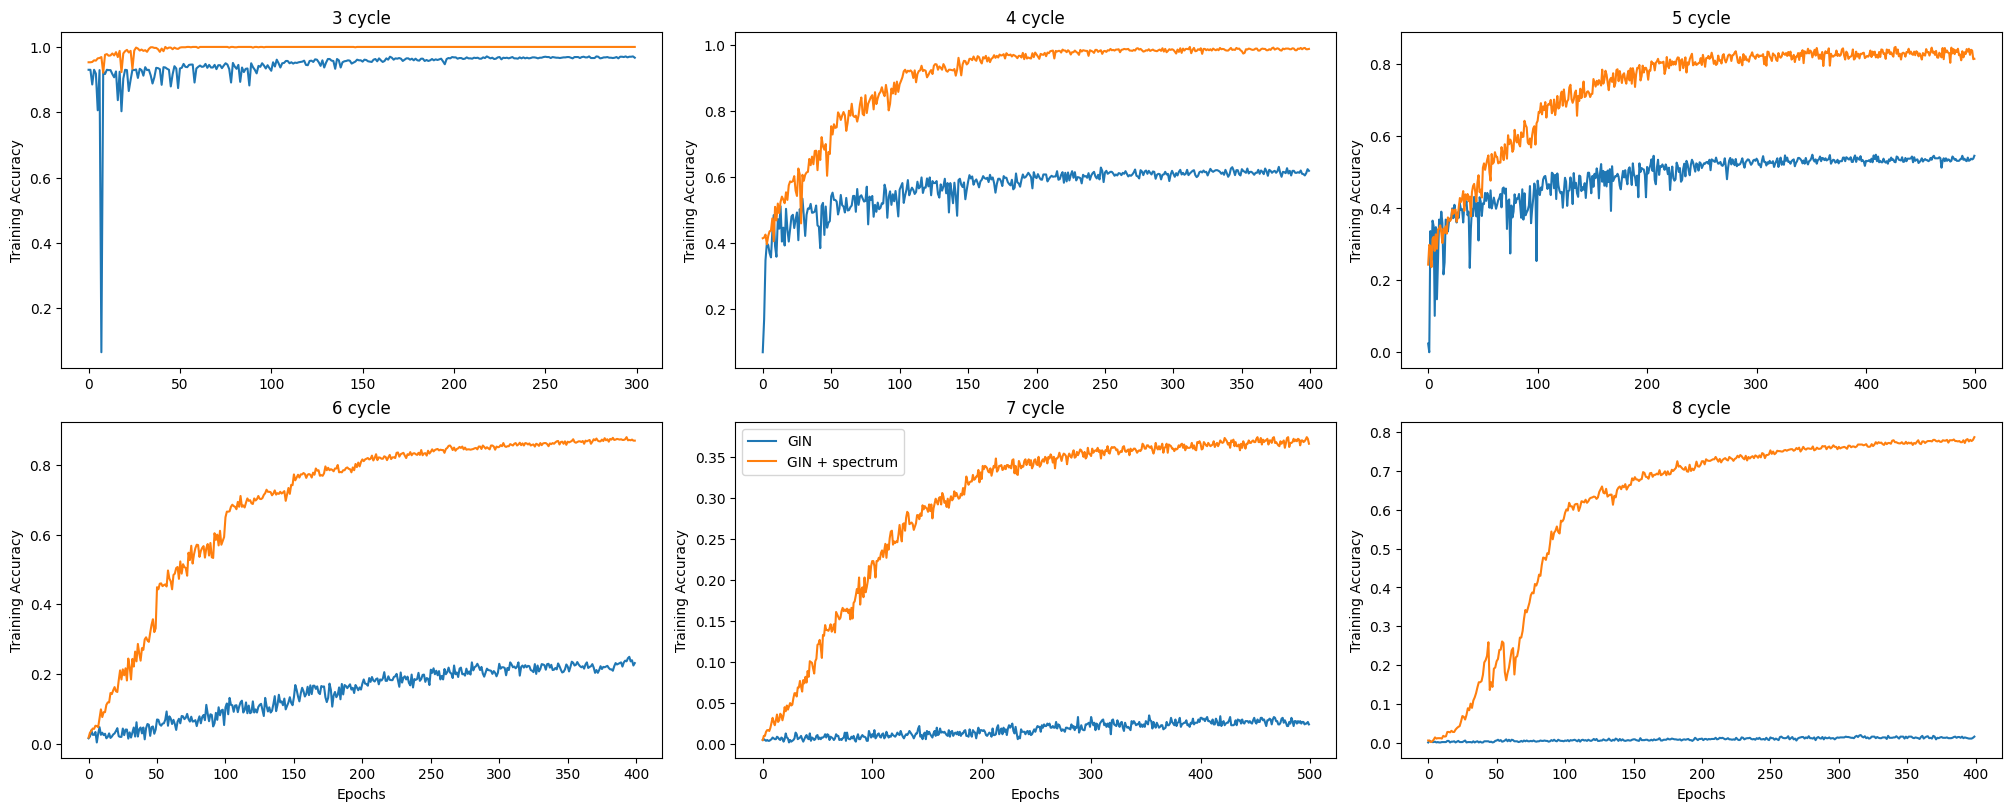

In [ ]:
#@title Plot

plt.figure(figsize=(20,8), constrained_layout=True)

for idx, cycle in enumerate(results):
  plt.subplot(2, 3, idx+1)

  for model, accs in cycle.items():
    plt.plot(range(len(accs)), accs, label=model)

  if idx > 2:
    plt.xlabel('Epochs')
  plt.ylabel('Training Accuracy')
  plt.title(f"{idx+3} cycle")

plt.subplot(2, 3, 5).legend(loc='upper left')
plt.show()

In [ ]:
#@title Best Accuracies

for idx, cycle in enumerate(results):
  for model, accs in cycle.items():
    best = max(accs)
    print("Best training accuracy of " + model + " on " + str(idx+3) + " cycle was " + str(best))

Best training accuracy of GIN on 3 cycle was 0.971
Best training accuracy of GIN + spectrum on 3 cycle was 1.0
Best training accuracy of GIN on 4 cycle was 0.63
Best training accuracy of GIN + spectrum on 4 cycle was 0.993
Best training accuracy of GIN on 5 cycle was 0.548
Best training accuracy of GIN + spectrum on 5 cycle was 0.847
Best training accuracy of GIN on 6 cycle was 0.249
Best training accuracy of GIN + spectrum on 6 cycle was 0.88
Best training accuracy of GIN on 7 cycle was 0.035
Best training accuracy of GIN + spectrum on 7 cycle was 0.374
Best training accuracy of GIN on 8 cycle was 0.02
Best training accuracy of GIN + spectrum on 8 cycle was 0.787
